In [ ]:
#Importing all the necessary header files
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from IPython.display import Image, display
import time
import matplotlib.pyplot as plt

In [ ]:
#Reading the Base Image and the Style Image
base_image_path = keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_reference_image_path = keras.utils.get_file("6a6151155fbde50cec7b9616661c1448d3374fa7.jpg", "https://ka-perseus-images.s3.amazonaws.com/6a6151155fbde50cec7b9616661c1448d3374fa7.jpg")
result_prefix = "paris_generated"

In [ ]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [ ]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

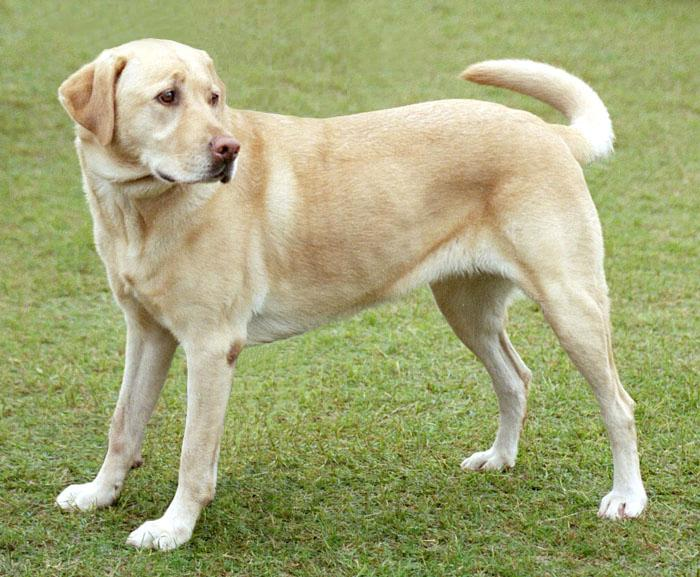

In [ ]:
# Displaying the Base Image
display(Image(base_image_path))

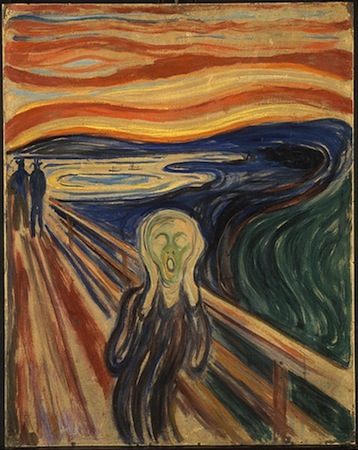

In [ ]:
#Displaying the Style Image
display(Image(style_reference_image_path))

In [ ]:
# A helper function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [ ]:
# A helper function to convert a tensor back to a valid image
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
# The below function computes the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [ ]:
# The "style loss" is designed to maintain the style of the reference image in the generated image. It is based on the gram matrices (which capture style) of feature maps from the style reference image and from the generated image

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
# An auxiliary loss function designed to maintain the "content" of the base image in the generated image

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [ ]:
# The 3rd loss function, total variation loss, designed to keep the generated image locally coherent

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

print("The Model Summary for the Pre-Trained VGG-19 Model")
model.summary()

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

The Model Summary for the Pre-Trained VGG-19 Model
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_poo

In [ ]:
# We are cherry picking the layers for the style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# Similarly, we're going to use block5_conv2 for the content loss.
content_layer_name = "block5_conv2"

In [ ]:
# A function to compute all the weighted loss
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    cl = content_loss(base_image_features, combination_features)
    loss += content_weight * cl

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    vl = total_variation_loss(combination_image)
    loss += total_variation_weight * vl
    return loss, cl , sl, vl

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, cl, sl, vl = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads, cl, sl, vl

In [ ]:
# Initalizing the optimizer
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

In [ ]:
# Pre-processing the input content image, style image and the combiation image

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [ ]:
# We're going to train the network for 4000 iterations, and paralley store the loss and the image generated
iterations = 4000
loss_store = []
cl_store = []
sl_store = []
vl_store = []
for i in range(0, iterations):
    epoch_time_start = int(time.time())
    loss, grads, cl,sl,vl = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    loss_store.append(loss)
    cl_store.append(cl)
    sl_store.append(sl)
    vl_store.append(vl)
    optimizer.apply_gradients([(grads, combination_image)])
    epoch_time_end = int(time.time())
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f " % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 0: loss=27887.93 
Iteration 100: loss=3609.44 
Iteration 200: loss=2691.32 
Iteration 300: loss=2322.18 
Iteration 400: loss=2113.62 
Iteration 500: loss=1974.60 
Iteration 600: loss=1873.37 
Iteration 700: loss=1795.82 
Iteration 800: loss=1733.35 
Iteration 900: loss=1681.65 
Iteration 1000: loss=1638.40 
Iteration 1100: loss=1601.73 
Iteration 1200: loss=1570.12 
Iteration 1300: loss=1542.66 
Iteration 1400: loss=1518.44 
Iteration 1500: loss=1496.84 
Iteration 1600: loss=1477.46 
Iteration 1700: loss=1459.99 
Iteration 1800: loss=1444.20 
Iteration 1900: loss=1429.73 
Iteration 2000: loss=1416.44 
Iteration 2100: loss=1404.23 
Iteration 2200: loss=1392.96 
Iteration 2300: loss=1382.58 
Iteration 2400: loss=1372.97 
Iteration 2500: loss=1364.06 
Iteration 2600: loss=1355.79 
Iteration 2700: loss=1348.09 
Iteration 2800: loss=1340.92 
Iteration 2900: loss=1334.21 
Iteration 3000: loss=1327.93 
Iteration 3100: loss=1322.06 
Iteration 3200: loss=1316.52 
Iteration 3300: loss=

In [ ]:
# Plot Curves
def plot_graph(epocs,attribute_a,attribute_b,attribute_c,attribute_d):
  fig, ax = plt.subplots(2, 2,figsize=(10,10))

  ax[0,0].plot(range(epocs),attribute_a[:epocs],'-',color='green',linewidth=3,label='Content Loss')
  #ax[0,0].xlabel('epoch')
  #ax[0,0].ylabel(loss_name)
  ax[0,0].grid(True)
  ax[0,0].legend()

  ax[1,0].plot(range(epocs),attribute_b[:epocs],'-',color='orange',linewidth=3,label='Style Loss')
  #ax[1,0].xlabel('epoch')
  #ax[1,0].ylabel(loss_name)
  ax[1,0].grid(True)
  ax[1,0].legend()

  ax[0,1].plot(range(epocs),attribute_c[:epocs],'-',color='red',linewidth=3,label='Variation Loss')
  #ax[0,1].xlabel('epoch')
  #ax[0,1].ylabel(loss_name)
  ax[0,1].grid(True)
  ax[0,1].legend()

  ax[1,1].plot(range(epocs),attribute_d[:epocs],'-',color='blue',linewidth=3,label='Overall Loss')
  #ax[1,1].xlabel('epoch')
  #ax[1,1].ylabel(loss_name)
  ax[1,1].grid(True)
  ax[1,1].legend()

  plt.setp(ax[0, 0], xlabel='Iteration', ylabel='Loss')
  plt.setp(ax[0, 1], xlabel='Iteration', ylabel='Loss')
  plt.setp(ax[1, 0], xlabel='Iteration', ylabel='Loss')
  plt.setp(ax[1, 1], xlabel='Iteration', ylabel='Loss')

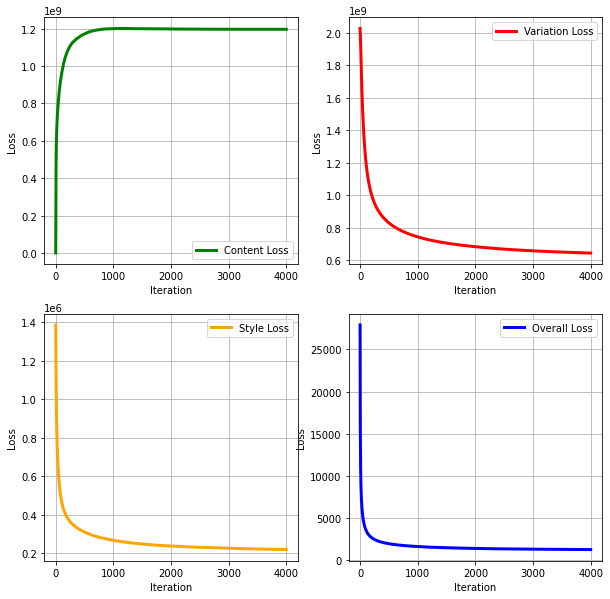

In [ ]:
plot_graph(4000,cl_store,sl_store,vl_store,loss_store)

In [ ]:
"""
plt.plot(range(100),cl_store,'-',linewidth=3,label='Train error')
plt.plot(range(100),sl_store,'-',linewidth=3,label='Test error')
plt.plot(range(100),vl_store,'-',linewidth=3,label='Train error')
plt.plot(range(100),loss_store,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
"""

"\nplt.plot(range(100),cl_store,'-',linewidth=3,label='Train error')\nplt.plot(range(100),sl_store,'-',linewidth=3,label='Test error')\nplt.plot(range(100),vl_store,'-',linewidth=3,label='Train error')\nplt.plot(range(100),loss_store,'-',linewidth=3,label='Test error')\nplt.xlabel('epoch')\nplt.ylabel('loss')\nplt.grid(True)\nplt.legend()\n"





*   Display Image at 25, 75, 200
*   Time taken to train for 1000 epochs







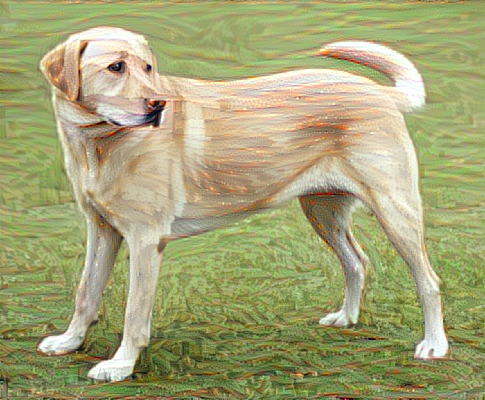

In [ ]:
display(Image(result_prefix + "_at_iteration_100.png"))

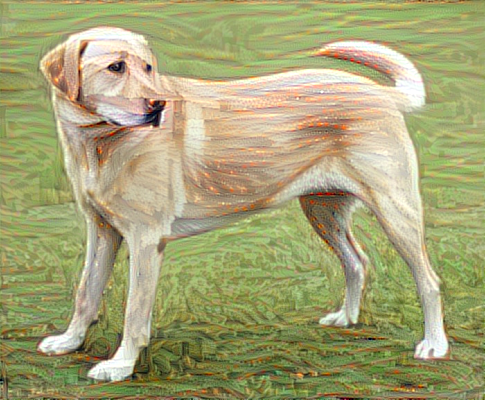

In [ ]:
display(Image(result_prefix + "_at_iteration_200.png"))

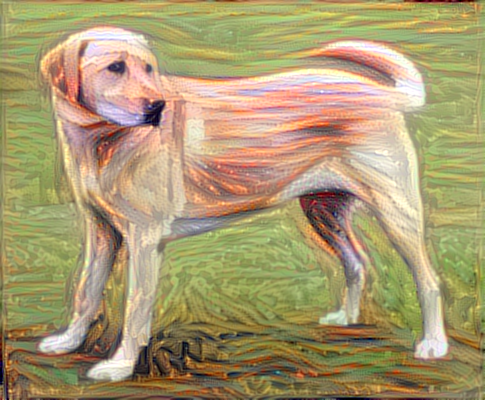

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))